In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq self-supervised

In [ ]:
#default_exp vision.moco

# MoCo

> MoCo: [Momentum Contrast for Unsupervised Visual Representation Learning](https://arxiv.org/pdf/1911.05722.pdf) 

> MoCo V2: [Improved Baselines with Momentum Contrastive Learning](https://arxiv.org/pdf/2003.04297.pdf)

In [ ]:
#export
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *

## Algorithm

#### MoCo 

![](images/moco.png)

**Absract (MoCo V2)**: Contrastive unsupervised learning has recently shown
encouraging progress, e.g., in Momentum Contrast (MoCo)
and SimCLR. In this note, we verify the effectiveness of two
of SimCLR’s design improvements by implementing them in
the MoCo framework. With simple modifications to MoCo—
namely, using an MLP projection head and more data
augmentation—we establish stronger baselines that outperform
SimCLR and do not require large training batches. We
hope this will make state-of-the-art unsupervised learning
research more accessible. Code will be made public.

In [ ]:
#export
class MoCoModel(Module):
    # TODO: Add queue as buffer to torch module, is it needed for distrib??
    "MoCo model"
    def __init__(self,encoder,projector): 
        self.encoder,self.projector = encoder,projector
    
    def forward(self,x): 
        return F.normalize(self.projector(self.encoder(x)), dim=1)

You can either use `MoCoModel` module to create a model by passing predefined `encoder` and `projector` models or you can use `create_moco_model` with just passing predefined encoder and expected input channels. In new MoCo paper, model consists of an encoder and a mlp projector following the SimCLR-v2 improvements.

You may refer to: [official implementation](https://github.com/facebookresearch/moco/blob/78b69cafae80bc74cd1a89ac3fb365dc20d157d3/moco/builder.py#L126)

In [ ]:
#export
def create_moco_model(encoder, hidden_size=256, projection_size=128, bn=False, nlayers=2):
    "Create MoCo model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=bn, nlayers=nlayers) 
    apply_init(projector)
    return MoCoModel(encoder, projector)

In [ ]:
encoder = create_encoder("tf_efficientnet_b0_ns", n_in=3, pretrained=False, pool_type=PoolingType.CatAvgMax)
model = create_moco_model(encoder, hidden_size=2048, projection_size=128)
out = model(torch.randn((2,3,224,224))); out.shape

torch.Size([2, 128])

## MoCo Callback

The following parameters can be passed;

- **aug_pipelines** list of augmentation pipelines List[Pipeline] created using functions from `self_supervised.augmentations` module. Each `Pipeline` should be set to `split_idx=0`. You can simply use `get_moco_aug_pipelines` utility to get aug_pipelines.
- **K** is queue size. For simplicity K needs to be a multiple of batch size and it needs to be less than total training data. You can try out different values e.g. `bs*2^k` by varying k where bs i batch size.
- **m** is momentum for key encoder update. `0.999` is a good default according to the paper.
- **temp** temperature scaling for cross entropy loss similar to `SimCLR`


You may refer to [official implementation](https://github.com/facebookresearch/moco/)

Our implementation doesn't uses [shuffle BN](https://github.com/facebookresearch/moco/blob/78b69cafae80bc74cd1a89ac3fb365dc20d157d3/moco/builder.py#L69) and instead it uses current batch for both positives and negatives during loss calculation. This should handle the "signature" issue coming from batchnorm which is argued to be allowing model to cheat for same batch positives. This modification not only creates simplicity but also allows training with a single GPU. Official Shuffle BN implementation depends on DDP (DistributedDataParallel) and only supports multiple GPU environments. Unfortunately, not everyone has access to multiple GPUs and we hope with this modification MoCo will be more accessible now.

For more details about our proposed custom implementation you may refer to this [Github issue](https://github.com/facebookresearch/moco/issues/24#issuecomment-787201146).

MoCo algorithm uses 2 views of a given image, and `MOCO` callback expects a list of 2 augmentation pipelines in `aug_pipelines`.

You can simply use helper function `get_moco_aug_pipelines()` which will allow augmentation related arguments such as size, rotate, jitter...and will return a list of 2 pipelines, which we can be passed to the callback. This function uses `get_multi_aug_pipelines` which then `get_batch_augs`. For more information you may refer to `self_supervised.augmentations` module.

Also, you may choose to pass your own list of aug_pipelines which needs to be List[Pipeline, Pipeline] where Pipeline(..., split_idx=0). Here, `split_idx=0` forces augmentations to be applied in training mode.

In [ ]:
#export
@delegates(get_multi_aug_pipelines)
def get_moco_aug_pipelines(size, **kwargs): return get_multi_aug_pipelines(n=2, size=size, **kwargs)

In [ ]:
#export
from copy import deepcopy

class MOCO(Callback):
    order,run_valid = 9,True
    def __init__(self,  aug_pipelines, K,  m=0.999, temp=0.07, print_augs=False):        
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('K,m,temp')

            
    def before_fit(self):
        "Create key encoder and init queue"
        if (not hasattr(self, "encoder_k")) and (not hasattr(self, "queue")):
            # init key encoder
            self.encoder_k = deepcopy(self.learn.model).to(self.dls.device)  
            for param_k in self.encoder_k.parameters(): param_k.requires_grad = False 
            # init queue
            nf = self.learn.model.projector[-1].out_features
            self.queue = torch.randn(self.K, nf).to(self.dls.device)
            self.queue = nn.functional.normalize(self.queue, dim=1)
            self.queue_ptr = 0
        else:warnings.warn("Key encoder and queue are already defined, keeping them.")

        self.learn.loss_func = self.lf
        
    def before_train(self):    self.encoder_k.train()
    def before_validate(self): self.encoder_k.eval()
    def before_batch(self):
        "Generate query and key for the current batch"
        q_img,k_img = self.aug1(self.x), self.aug2(self.x.clone())
        self.learn.xb = (q_img,)
        with torch.no_grad(): self.learn.yb = (self.encoder_k(k_img),)

    
    def lf(self, pred, *yb):
        q,k = pred,yb[0]
        logits = q @ torch.cat([k, self.queue]).T / self.temp # Nx(N+K) instead of original Nx(1+K)
        labels = torch.arange(len(q)).to(self.dls.device)
        return F.cross_entropy(logits, labels)
            

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        for param_q, param_k in zip(self.learn.model.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

            
    @torch.no_grad()
    def _dequeue_and_enqueue(self):
        bs = self.x.size(0)
        k = self.y
        assert self.K % bs == 0  # for simplicity
        self.queue[self.queue_ptr:self.queue_ptr+bs, :] = k
        self.queue_ptr = (self.queue_ptr + bs) % self.K  # move pointer

    
    def after_step(self):
        "Update momentum (key) encoder and queue"
        self._momentum_update_key_encoder()
        self._dequeue_and_enqueue()
          
            
    @torch.no_grad()
    def show(self, n=1):
        x1,x2  = self.aug1(self.x), self.aug2(self.x.clone())
        bs = x1.size(0)
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), ncols=None, nrows=n)

### Example Usage

In [ ]:
path = untar_data(URLs.MNIST_TINY)
items = get_image_files(path)
tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
dls = tds.dataloaders(bs=8, after_item=[ToTensor(), IntToFloatTensor()], device='cpu')

In [ ]:
fastai_encoder = create_encoder('xresnet18', n_in=1, pretrained=False)
model = create_moco_model(fastai_encoder, hidden_size=1024, projection_size=128, bn=True)
aug_pipelines = get_moco_aug_pipelines(size=28, rotate=False, jitter=False, bw=False, blur=False, stats=None, cuda=False)
learn = Learner(dls, model, cbs=[MOCO(aug_pipelines=aug_pipelines, K=128, print_augs=True), ShortEpochCallback(0.001)])

Pipeline: RandomResizedCrop -> RandomHorizontalFlip
Pipeline: RandomResizedCrop -> RandomHorizontalFlip


In [ ]:
learn.summary()

MoCoModel (Input shape: 8)
Layer (type)         Output Shape         Param #    Trainable 
                     8 x 32 x 14 x 14    
Conv2d                                    288        True      
BatchNorm2d                               64         True      
ReLU                                                           
Conv2d                                    9216       True      
BatchNorm2d                               64         True      
ReLU                                                           
____________________________________________________________________________
                     8 x 64 x 14 x 14    
Conv2d                                    18432      True      
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
Conv2d                                    36864      True      
BatchNorm2d                               12

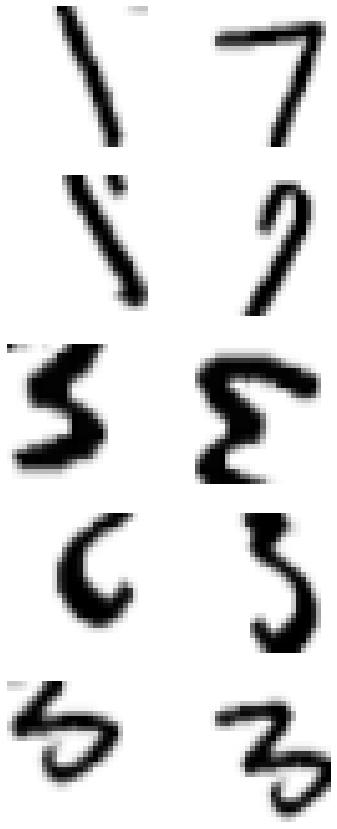

In [ ]:
b = dls.one_batch()
learn._split(b)
learn.pred = learn.model(*learn.xb)
axes = learn.moco.show(n=5)

In [ ]:
learn.fit(1)

/Users/turgutlu/anaconda3/envs/fastai/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: Key encoder and queue are already defined, keeping them.


In [ ]:
learn.recorder.losses

[tensor(1.2937)]

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 01 - augmentations.ipynb.
Converted 02 - layers.ipynb.
Converted 03 - distributed.ipynb.
Converted 10 - simclr.ipynb.
Converted 11 - moco.ipynb.
Converted 12 - byol.ipynb.
Converted 13 - swav.ipynb.
Converted 14 - barlow_twins.ipynb.
Converted 20 - clip.ipynb.
Converted 21 - clip-moco.ipynb.
Converted 70 - vision.metrics.ipynb.
Converted index.ipynb.
